# Jester dataset

In [1]:
import numpy as np
import pandas as pd
from interactions_data import make_long
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import zipfile
import os, shutil
from glob import glob

Benchmark score can be found [here](https://www.aaai.org/Papers/ICML/2003/ICML03-094.pdf)   
Joke files can be found [here](http://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip)

### Download and save data

In [2]:
try:
    shutil.rmtree('./jester')
    print('jester directory already exists, removing it first')
except:
    print('no existing directory found, all good')

# stable link for dataset
url = 'http://eigentaste.berkeley.edu/dataset/'
files = ['jester_dataset_1_1.zip', 'jester_dataset_1_2.zip', 'jester_dataset_1_3.zip', 'jester_dataset_1_joke_texts.zip']

# download zip files from links
for file in files:
    print('downloading and saving ', file)
    downloaded = urlopen(url + file)
    buf = downloaded.read()

    # save file and extract contents
    with open(file, 'wb') as f:
        f.write(buf)

    print('unzipping contents')
    with zipfile.ZipFile(file) as zip:
        zip.extractall('./jester')
    
    # remove zip file from directory
    print('deleting zip file')
    os.remove(file)

# remove these unwanted files
shutil.rmtree('./jester/__MACOSX')
os.remove('./jester/jokes/.DS_Store')

jester directory already exists, removing it first
downloading and saving  jester_dataset_1_1.zip
unzipping contents
deleting zip file
downloading and saving  jester_dataset_1_2.zip
unzipping contents
deleting zip file
downloading and saving  jester_dataset_1_3.zip
unzipping contents
deleting zip file
downloading and saving  jester_dataset_1_joke_texts.zip
unzipping contents
deleting zip file


In [3]:
path = 'jester/'

In [4]:
ratings = glob(path+'jester-data-*.xls')

In [5]:
df = pd.concat((pd.read_excel(file, names=['numRatings'] + [i for i in range(100)]) for file in ratings), ignore_index=True)
df = df.drop('numRatings', axis=1)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
1,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
2,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
3,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
4,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,-8.69,-0.87,-6.65,-1.80,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45


In [7]:
df.shape

(73418, 100)

In [8]:
# 99.0 is used to represent no rating
df.replace(99.0, np.nan, inplace=True)

## Convert data into long format

In [9]:
df['userId'] = df.index.values
df = df.melt(id_vars='userId', var_name='jokeId', value_name='rating').dropna()

In [10]:
df.head()

,userId,jokeId,rating
0,0,0,4.08
3,3,0,8.50
4,4,0,-6.17
6,6,0,6.84
7,7,0,-3.79


In [11]:
df.shape

(4136210, 3)

### Check that IDs range from 0-n

In [12]:
print(df.userId.max(), df['userId'].nunique())
print(df.jokeId.max(), df['jokeId'].nunique())

73417 73418
99 100


### Train / test split

In [13]:
ratings1, ratings2, _, _ = train_test_split(df, df.rating,
                                            test_size = .3,
                                            random_state=42)

In [14]:
# split train into 2 files to allow github storage
ratings1, ratings3, _, _ = train_test_split(ratings1, ratings1.rating,
                                            test_size = .5,
                                            random_state=42)

In [15]:
ratings1.shape, ratings2.shape, ratings3.shape

((1447673, 3), (1240863, 3), (1447674, 3))

In [16]:
ratings1.to_csv(path+'ratings1.csv', index=False)
ratings2.to_csv(path+'ratings2.csv', index=False)
ratings3.to_csv(path+'ratings3.csv', index=False)

### remove all other files

In [17]:
folder = os.listdir('./'+path)

for item in folder:
    if item.endswith(".xls"):
        os.remove(os.path.join('./'+path, item))

## EDA

In [18]:
ratings = glob(path+'r*.csv')

In [19]:
# load all of train and test data as one dataframe
df = pd.concat((pd.read_csv(file) for file in ratings), ignore_index=True)

In [20]:
df.shape

(4136210, 3)

In [21]:
df.head()

,userId,jokeId,rating
0,44153,30,-0.10
1,35152,19,-8.16
2,19138,47,6.46
3,35092,31,-2.38
4,7704,37,5.92


In [22]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (16,9),
            'font.family': 'serif'})

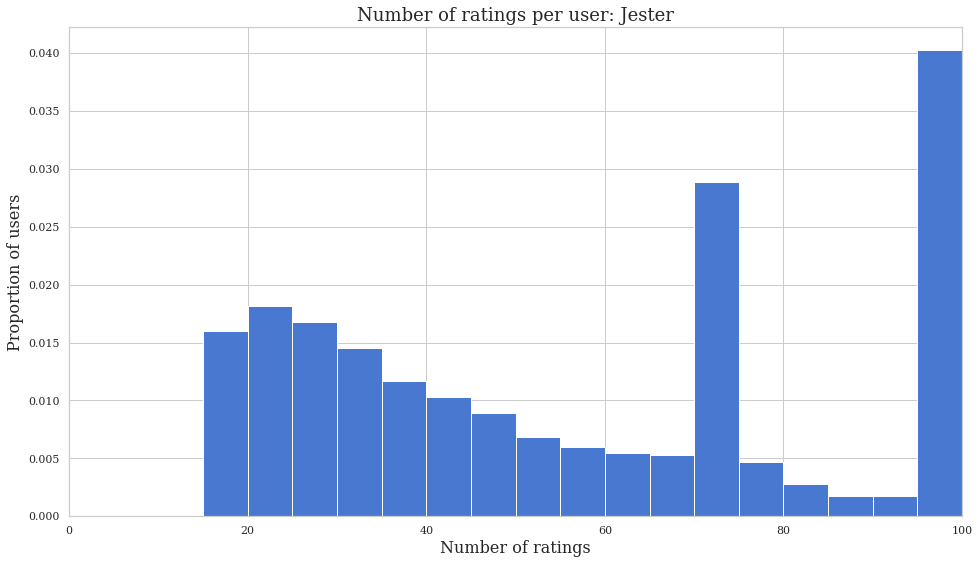

Min ratings by single user: 15
Max ratings by single user: 100
Avg number of ratings per user: 56


In [23]:
user_counts = df['userId'].value_counts()

plt.hist(user_counts, bins=np.arange(0,101,5), density=True)
plt.title('Number of ratings per user: Jester', fontsize=18)
plt.xlabel('Number of ratings', fontsize=16)
plt.ylabel('Proportion of users', fontsize=16)
plt.xlim(0, 100)
# plt.xticks(np.arange(0,1251,250))
plt.savefig('../figures/jester_user-ratings.pdf', bbox_inches='tight')
plt.show()

# user with fewest ratings
print('Min ratings by single user:',
      user_counts.min())

# user with most ratings
print('Max ratings by single user:',
      user_counts.max())

# average number of ratings per user
print('Avg number of ratings per user:',
      round(user_counts.mean()))

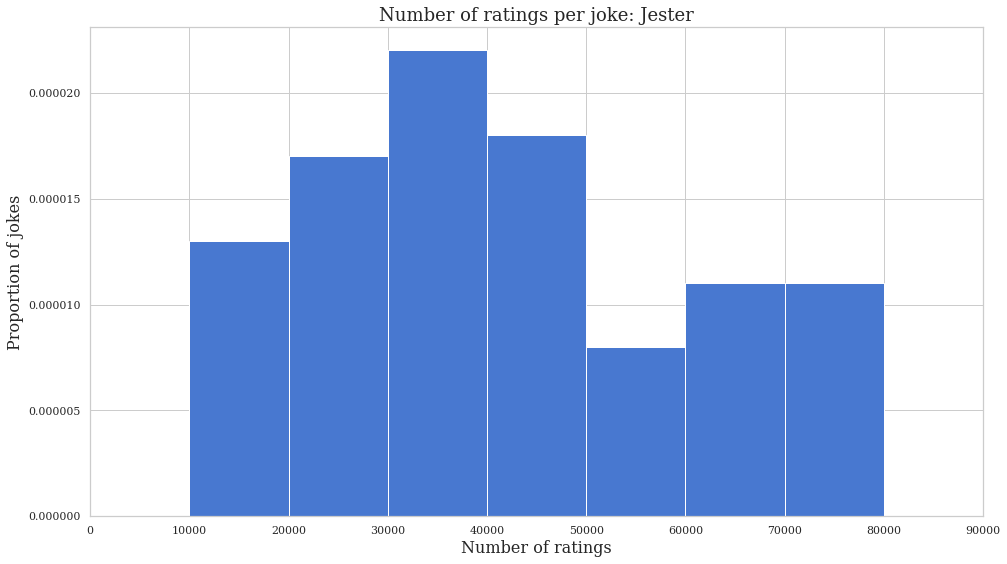

Min ratings of single joke: 18505
Max ratings of single joke: 73410
Avg number of ratings per joke: 41362


In [24]:
joke_counts = df['jokeId'].value_counts()

plt.hist(joke_counts, bins=np.arange(0,80001,10000), density=True)
plt.title('Number of ratings per joke: Jester', fontsize=18)
plt.xlabel('Number of ratings', fontsize=16)
plt.ylabel('Proportion of jokes', fontsize=16)
plt.xlim(0, 90000)
# plt.xticks(np.arange(0,4001,500))
plt.savefig('../figures/jester_joke-ratings.pdf', bbox_inches='tight')
plt.show()

# joke with fewest ratings
print('Min ratings of single joke:',
      joke_counts.min())

# joke with most ratings
print('Max ratings of single joke:',
      joke_counts.max())

# average number of ratings per joke
print('Avg number of ratings per joke:',
      round(joke_counts.mean()))

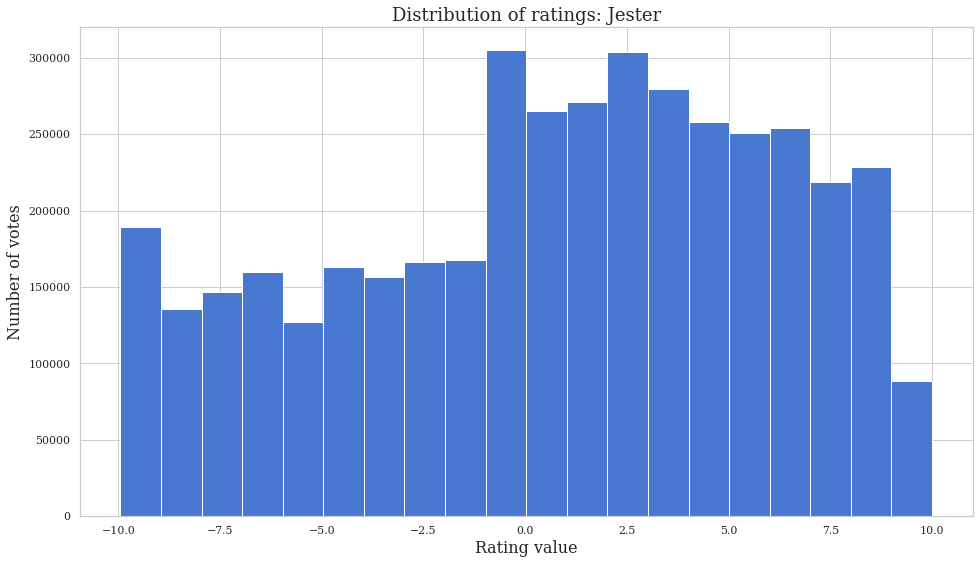

Avg rating: 0.74


In [25]:
plt.hist(df['rating'].values, bins=20)
plt.title('Distribution of ratings: Jester', fontsize=18)
plt.xlabel('Rating value', fontsize=16)
plt.ylabel('Number of votes', fontsize=16)
plt.savefig('../figures/jester_ratings-dist.pdf', bbox_inches='tight')
plt.show()

print('Avg rating:', round(df['rating'].mean(),2))

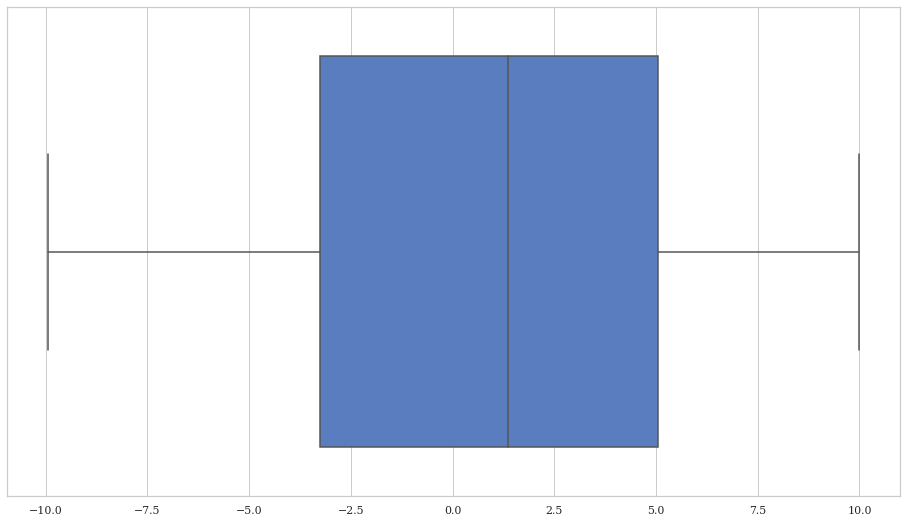

['Q2', 'Q3', 'Q5']
[-3.25  1.36  5.05]


In [24]:
sns.boxplot(df['rating'].values)
plt.show()

print((['Q2','Q3','Q5']))
print(np.percentile(df.rating.values, [25,50,75]))

## Create jokes metadata file
This requires some webscraping and some NLP - fun!

In [27]:
from bs4 import BeautifulSoup
from itertools import cycle
import time
from tqdm import tqdm

In [31]:
path = './jester/jokes/init1.html'

soup = BeautifulSoup(open(path), 'html.parser')

In [40]:
soup.find('body').text.replace('\n',' ')

'       A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer\'s disease".  The man replies "Well,thank God I don\'t have cancer!"    '